In [21]:
# Do not change this cell

import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchinfo import summary

import matplotlib.pyplot as plt
from timeit import default_timer as timer

import numpy as np

random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])


trainset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
validationset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
testset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=ToTensor()
)
classes = trainset.classes
"""
trainset = 'data/FashionMNIST/raw/train-images-idx3-ubyte'
validationset = 'data/FashionMNIST/raw/train-images-idx3-ubyte'
testset = 'data/FashionMNIST/raw/t10k-images-idx1-ubyte'
"""
valid_size = 0.2
train_length = len(trainset)
indices = list(range(len(trainset)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]
train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f"Length of train data loader: {len(train_loader)} batches of {batch_size}")
print(f"Length of validation data loader: {len(valid_loader)} batches of {batch_size}")
print(f"Length of test data loader: {len(test_loader)} batches of {batch_size}")

# Check out what is inside the training data loader
train_features_batch, train_label_batch = next(iter(train_loader))
print(train_features_batch.shape, train_label_batch.shape)

Length of train data loader: 188 batches of 256
Length of validation data loader: 47 batches of 256
Length of test data loader: 40 batches of 256
torch.Size([256, 1, 28, 28]) torch.Size([256])


In [22]:
# Do not change this cell
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

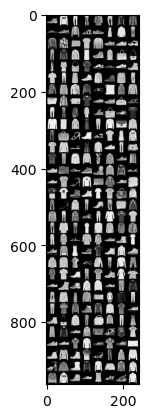

In [23]:
# Do not change this cell
dataiter = iter(test_loader)
images, labels = next(dataiter)
# Show images
imshow(torchvision.utils.make_grid(images))

In [24]:
# TODO: you will design your model here
class ConvModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ConvModel, self).__init__()
        # Define arch of CNN
        # Size of input (3, RGB), output (# filters), kernel (5x5), stride and padding
        self.conv1 = nn.Conv2d(input_size, 32, kernel_size=5, stride=1, padding=2)
        # Reduces spatial dimensions using 2x2 filter and stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Takes 32 channels input from conv1 and produces 64 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        
        # Size after first pool: (28/2)=14
        # Size after second: (14/2)=7
        
        # Two fully connected linear layers
        # fc1 takes flattened object and produces 128 features
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        # fc2 takes 128 input and produces the final output
        self.fc2 = nn.Linear(128, output_size)
        
        
    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten tensor
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
def train_step(model, train_loader, loss_fn, optimizer, reg_param, device):
    # Initialize model
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()  # Clear the gradients of all optimized vars
        output = model(data)  # Forward pass: compute predicted outputs by passing to the model
        loss = loss_fn(output, target)  # This is our prediction loss
        
        # L2 Regularization and loss calculation
        l2_reg = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        loss += reg_param * l2_reg  # Correct loss equation
        
        # Backward pass
        loss.backward()
        
        # 1 optimization
        optimizer.step()
        
        # Calculate total loss
        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
    # Calculate avg loss
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    # Return
    return avg_loss, accuracy

In [26]:
def evaluation_step(model, data_loader, loss_fn, reg_param, device):
    # Initialize model
    model.eval()
    total_loss = 0.0
    correct_predictions = 0.0
    total_samples = 0.0
    
    with torch.no_grad():  # Do not track gradients
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to device
            
            output = model(X_batch)  # Forward pass
            loss = loss_fn(output, y_batch)  # Compute batch loss
            
            if reg_param is not None:  # Apply L2 reg if reg_param > 0
                l2_reg = sum(p.pow(2.0).sum() for p in model.parameters())
                loss += reg_param * l2_reg  # Correct loss eqn
                
            total_loss += loss.item() * X_batch.size(0)  # Aggregate batch loss
            
            _, predicted = torch.max(output.data, 1)  # Get predictions
            correct_predictions += (predicted == y_batch).sum().item()  # Count correct preds
            total_samples += y_batch.size(0)  # Count total samples
            
        avg_loss = total_loss / total_samples  # Calc avg loss
        accuracy = correct_predictions / total_samples * 100
        
        return avg_loss, accuracy
    

In [27]:
def adjust_learning_rate(optimizer, epoch, initial_lr=0.45, decay_rate=0.99):
    """ Adjusts learning rate based on epoch number """
    lr = initial_lr * (decay_rate ** epoch)
    for param_group in optimizer.parameters:
        param_group.lr = lr

class SimpleGradDescentOptimizer:
    """ This is a simple optimizer which provides functions for 
        optimization steps and zeroing out the gradient. """
    def __init__(self, parameters, lr=0.45):
        self.parameters = list(parameters)
        self.lr = lr

    def step(self):
        """ Perform a single optimization step """
        with torch.no_grad():
            for param in self.parameters:
                if param.grad is not None:
                    param -= self.lr * param.grad

    def zero_grad(self):
        """ Clear gradients of all optimized parameters """
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()
                
def train_conv_model(train_loader, valid_loader, test_loader, random_seed):
    torch.manual_seed(random_seed)  # do not change this
    
    # Make device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    #else:
        #if torch.backends.mps.is_available():
            #device = "mps"
    
    # Model initialization
    input_size = 1 
    output_size = len(classes)  # Output classes
    model = ConvModel(input_size, output_size).to(device)
    
    # Loss fn
    loss_fn = nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = SimpleGradDescentOptimizer(model.parameters(), lr=0.45)
    
    # Regularization p
    reg_param = 0.001
    
    # Trackers
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    test_losses, test_accuracies = [], []
    
    num_epochs = 25
    
    for epoch in range(num_epochs):
        start_time = timer()
        adjust_learning_rate(optimizer, epoch)
        
        # Training step
        train_loss, train_accuracy = train_step(model, train_loader, loss_fn, optimizer, reg_param, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation step
        valid_loss, valid_accuracy = evaluation_step(model, valid_loader, loss_fn, reg_param, device)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        
        end_time = timer()

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Valid Loss: {valid_loss:.4f}, "
              f"Valid Accuracy: {valid_accuracy:.2f}%, "
              f"Time: {end_time - start_time:.2f}s")
        
        # Test step
        test_loss, test_accuracy = evaluation_step(model, test_loader, loss_fn, reg_param, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies
    

In [28]:
def plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies):
    plt.figure(figsize=(10, 6))  # make plt object
    epochs = range(1, len(train_accuracies) + 1)  # size of x
    
    # Plot training and test acc, as well as validation
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')  # y-axis for train
    plt.plot(epochs, test_accuracies, 'ro-', label='Test Accuracy')  # y-axis for test
    plt.plot(epochs, valid_accuracies, 'go-', label='Validation Accuracy')
    
    
    # Title and Labels
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    # Legend
    plt.legend()
    plt.show()

In [29]:
def plot_loss_performance(train_losses, valid_accuracies, test_losses):
    plt.figure(figsize=(10, 6))  # make plt object
    epochs = range(1, len(train_accuracies) + 1)  # size of x
    
    # Plot training and test losses, as well as validation
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')  # y-axis for train
    plt.plot(epochs, test_losses, 'ro-', label='Test Loss')  # y-axis for test
    plt.plot(epochs, valid_accuracies, 'go-', label='Validation Loss')  # y-axis for validation
    
    # Title and Labels
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # Legend
    plt.legend()
    plt.show()

In [30]:
# Do not change this cell
random_seed = 1
model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies\
= train_conv_model(train_loader, valid_loader, test_loader, random_seed)

Epoch 1/25 - Train Loss: 0.9281, Train Accuracy: 65.76%, Valid Loss: 0.6572, Valid Accuracy: 80.85%, Time: 41.30s
Test Loss: 0.6715, Test Accuracy: 80.12%
Epoch 2/25 - Train Loss: 0.4412, Train Accuracy: 84.47%, Valid Loss: 0.5373, Valid Accuracy: 86.88%, Time: 40.89s
Test Loss: 0.5536, Test Accuracy: 86.55%
Epoch 3/25 - Train Loss: 0.3706, Train Accuracy: 87.27%, Valid Loss: 0.5258, Valid Accuracy: 87.44%, Time: 41.29s
Test Loss: 0.5490, Test Accuracy: 87.11%
Epoch 4/25 - Train Loss: 0.3349, Train Accuracy: 88.72%, Valid Loss: 0.5257, Valid Accuracy: 88.46%, Time: 41.40s
Test Loss: 0.5448, Test Accuracy: 87.86%
Epoch 5/25 - Train Loss: 0.3076, Train Accuracy: 89.72%, Valid Loss: 0.5123, Valid Accuracy: 89.55%, Time: 41.27s
Test Loss: 0.5359, Test Accuracy: 89.24%
Epoch 6/25 - Train Loss: 0.2896, Train Accuracy: 90.46%, Valid Loss: 0.5190, Valid Accuracy: 89.84%, Time: 40.89s
Test Loss: 0.5402, Test Accuracy: 89.55%
Epoch 7/25 - Train Loss: 0.2739, Train Accuracy: 90.90%, Valid Loss: 0

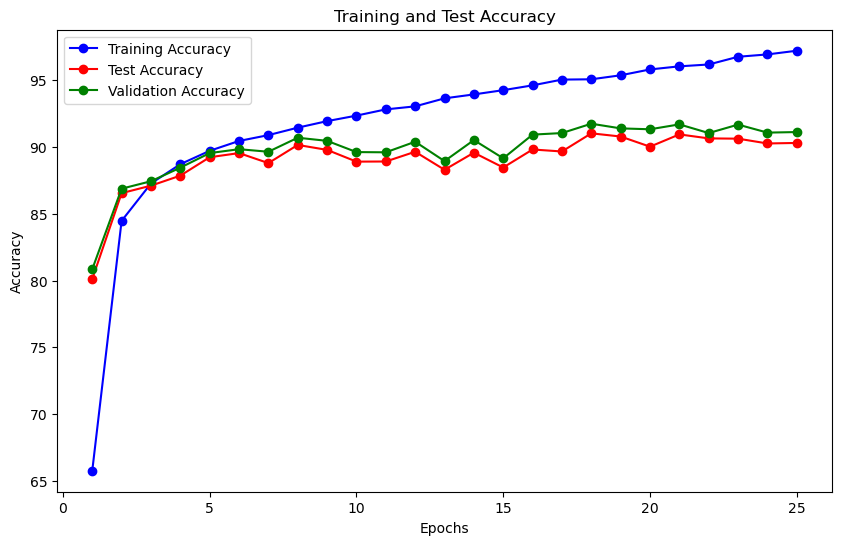

In [31]:
# Do not change this cell
plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies)

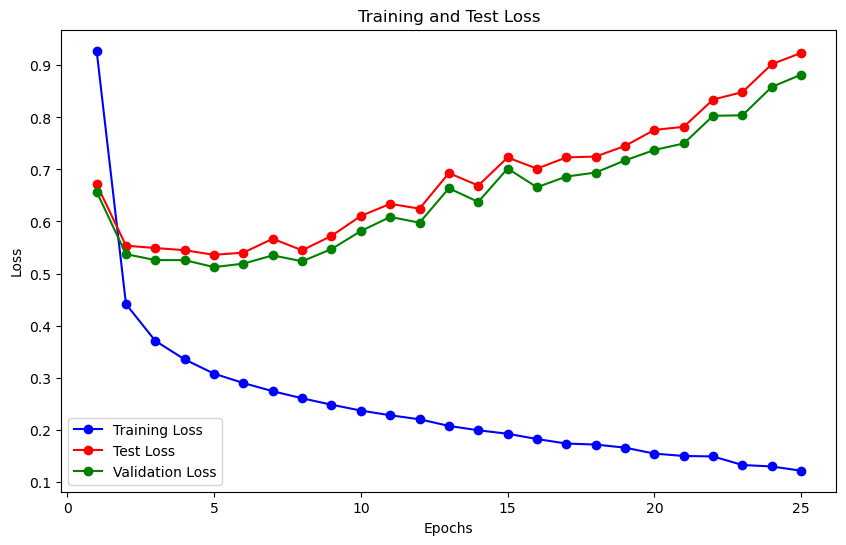

In [32]:
# Do not change this cell
plot_loss_performance(train_losses, valid_losses, test_losses)